In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms
from copy import deepcopy

# Hyper-parameter

In [2]:
######################## 문제 1 ########################
# 1. batch_size => 64으로 설정
# 2. n_epochs => 20으로 설정
# 3. train_ratio => 0.8으로 설정
config = {
    'use_batch_norm': True,
    'model_fn': 'FCN.pth',
    'train_ratio': 0.8,
    'batch_size': 64,
    'n_epochs': 20,
    'n_layers': 4,
    'model': 'fc',
    'verbose': 1
}
########################################################

# model

In [3]:
class Block(nn.Module):
  
  def __init__(self,
                input_size,
                output_size,
                use_batch_norm=True,
                dropout_p=.3):
      self.input_size = input_size
      self.output_size = output_size
      self.use_batch_norm = use_batch_norm
      self.dropout_p = dropout_p
      
      super().__init__()
      
      def get_regularizer(use_batch_norm, size):
          return nn.BatchNorm1d(size) if use_batch_norm else nn.Dropout(dropout_p)
      
      ######################## 문제 2 ########################
      # nn.Sequential를 통해 block 만들기 
      # 1. nn.Linear를 통해 input_size와 output_size 차원에 맞게 코드 구현
      # 2. ReLU 구현
      # 3. get_regularizer 메서드 호출을 통해 output_size에 맞는 BatchNorm1d return 받는 코드 구현  
      self.block = nn.Sequential(
          nn.Linear(input_size, output_size),
          nn.LeakyReLU(),
          get_regularizer(use_batch_norm, output_size),
      )
      ########################################################
      
  def forward(self, x):
      # |x| = (batch_size, input_size)
      y = self.block(x)
      # |y| = (batch_size, output_size)
      
      return y
    
class FullyConnectedNet(nn.Module):

  def __init__(self,
                input_size,
                output_size,
                hidden_sizes=[500, 400, 300, 200, 100],
                use_batch_norm=True,
                dropout_p=.3):
      
      super().__init__()

      assert len(hidden_sizes) > 0, "You need to specify hidden layers"

      last_hidden_size = input_size
      blocks = []
      for hidden_size in hidden_sizes:
          blocks += [Block(
              last_hidden_size,
              hidden_size,
              use_batch_norm,
              dropout_p
          )]
          last_hidden_size = hidden_size
      
      self.layers = nn.Sequential(
          *blocks,
          nn.Linear(last_hidden_size, output_size),
          nn.LogSoftmax(dim=-1),
      )
      
  def forward(self, x):
      # |x| = (batch_size, input_size)        
      y = self.layers(x)
      # |y| = (batch_size, output_size)
      
      return y



# utils




In [4]:
def load_mnist(is_train=True, flatten=True):
  dataset = datasets.FashionMNIST(
      '../Fashion_mnist_data', train=is_train, download=True,
      transform=transforms.Compose([
          transforms.ToTensor()
      ])
  )

  x = dataset.data.float() / 255
  y = dataset.targets

  if flatten:
    x = x.view(x.size(0), -1)

  return x, y

In [5]:
def split_data(x, y, config):
  dataset = TensorDataset(x, y)
  
  train_cnt = int(len(x)*config['train_ratio'])
  valid_cnt = len(x) - train_cnt

  train_dataset, valid_dataset = random_split(dataset, [train_cnt, valid_cnt])
  print("# of train_dataset : ", len(train_dataset))
  print("# of valid_dataset : ", len(valid_dataset))

  train_loader = DataLoader(dataset=train_dataset, batch_size=config['batch_size'], shuffle=True)
  valid_loader = DataLoader(dataset=valid_dataset, batch_size=config['batch_size'])

  return train_loader, valid_loader

In [6]:
def get_hidden_sizes(input_size, output_size, n_layers):
    step_size = int((input_size - output_size) / n_layers)

    hidden_sizes = []
    current_size = input_size
    for i in range(n_layers - 1):
        hidden_sizes += [current_size - step_size]
        current_size = hidden_sizes[-1]

    return hidden_sizes

# trainer

In [7]:
class Trainer():

    def __init__(self, model, optimizer, crit):
        self.model = model
        self.optimizer = optimizer
        self.crit = crit

    def _train(self, train_loader, config):
        self.model.train()

        total_loss = 0

        for i, (x_i, y_i) in enumerate(train_loader):
            y_hat_i = self.model(x_i)
            loss_i = self.crit(y_hat_i, y_i.squeeze())

            # Initialize the gradients of the model.
            self.optimizer.zero_grad()
            loss_i.backward()

            self.optimizer.step()
            
            if config['verbose'] >= 2:
                print("Train Iteration(%d/%d): loss=%.4e" % (i + 1, len(train_loader), float(loss_i)))

            # Don't forget to detach to prevent memory leak.
            total_loss += float(loss_i)

        return total_loss / len(train_loader)

    def _validate(self, valid_loader, config):
        # Turn evaluation mode on.
        self.model.eval()

        # Turn on the no_grad mode to make more efficintly.
        with torch.no_grad():
            total_loss = 0

            for i, (x_i, y_i) in enumerate(valid_loader):
                y_hat_i = self.model(x_i)
                loss_i = self.crit(y_hat_i, y_i.squeeze())
                
                if config['verbose'] >= 2:
                    print("Valid Iteration(%d/%d): loss=%.4e" % (i + 1, len(valid_loader), float(loss_i)))

                total_loss += float(loss_i)

            return total_loss / len(valid_loader)

    def train(self, train_loader, valid_loader, config):
        lowest_loss = np.inf
        best_model = None

        for epoch_index in range(config['n_epochs']):
            train_loss = self._train(train_loader, config)
            valid_loss = self._validate(valid_loader, config)

            # You must use deep copy to take a snapshot of current best weights.
            if valid_loss <= lowest_loss:
                lowest_loss = valid_loss
                best_model = deepcopy(self.model.state_dict())

            print("Epoch(%d/%d): train_loss=%.4e  valid_loss=%.4e  lowest_loss=%.4e" % (
                epoch_index + 1,
                config['n_epochs'],
                train_loss,
                valid_loss,
                lowest_loss,
            ))

        # Restore to best model.
        self.model.load_state_dict(best_model)


# train

In [8]:
def main(config):
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  x, y = load_mnist(is_train=True, flatten=True)
  

  ######################## 문제 3 ########################
  # 1. input_size와 output_size의 데이터의 정보를 통해서 할당
  # ex) size or shape or max ...
  
  # input layer와 output layer의 노드 개수는 문제가 결정
  input_size = int(x.size(-1))
  output_size = int(max(y)) + 1
  ########################################################
  train_loader, valid_loader = split_data(x.to(device), y.to(device), config)

  model = FullyConnectedNet(
    input_size=input_size,
    output_size=output_size,
    hidden_sizes=get_hidden_sizes(input_size,
                                  output_size,
                                  config['n_layers']),
    use_batch_norm=config['use_batch_norm']
  ).to(device)

  optimizer = optim.Adam(model.parameters())
  crit = nn.NLLLoss()

  if config['verbose'] >= 1:
    print(model)
    print(optimizer)
    print(crit)

  trainer = Trainer(model, optimizer, crit)

  trainer.train(train_loader, valid_loader, config)

  # Save best model weights
  torch.save({
      'model': trainer.model.state_dict(),
      'opt': optimizer.state_dict(),
      'config': config,
  }, config['model_fn'])

In [9]:
# start 
main(config)

100%|██████████| 26421880/26421880 [00:02<00:00, 11807486.59it/s]


Extracting ../Fashion_mnist_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../Fashion_mnist_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 199967.18it/s]


Extracting ../Fashion_mnist_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../Fashion_mnist_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3726300.10it/s]


Extracting ../Fashion_mnist_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../Fashion_mnist_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6412912.68it/s]


Extracting ../Fashion_mnist_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../Fashion_mnist_data/FashionMNIST/raw

# of train_dataset :  48000
# of valid_dataset :  12000
FullyConnectedNet(
  (layers): Sequential(
    (0): Block(
      (block): Sequential(
        (0): Linear(in_features=784, out_features=591, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(591, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Block(
      (block): Sequential(
        (0): Linear(in_features=591, out_features=398, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): Block(
      (block): Sequential(
        (0): Linear(in_features=398, out_features=205, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(205, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )

# test

In [10]:
model_fn = "./FCN.pth"
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [11]:
labels_map = {0: 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat',
              5 : 'Sandal', 6 : 'Shirt', 7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}

In [12]:
def load(fn, device):
    d = torch.load(fn, map_location=device)
    
    return d['model'], d['config']

In [13]:
def plot(x, y_hat):
    for i in range(x.size(0)):
        img = (np.array(x[i].detach().cpu(), dtype='float')).reshape(28,28)

        plt.imshow(img, cmap='gray')
        plt.show()
        print("Predict:", labels_map[int(torch.argmax(y_hat[i], dim=-1))])

In [14]:
def test(model, x, y, to_be_shown=True):
    model.eval()
    
    with torch.no_grad():
        y_hat = model(x)

        correct_cnt = (y.squeeze() == torch.argmax(y_hat, dim=-1)).sum()
        total_cnt = float(x.size(0))
        
        accuracy = correct_cnt / total_cnt
        print("Accuracy: %.4f" % accuracy)
        
        if to_be_shown:
            plot(x, y_hat)

In [15]:
# Load MNIST test set.
x, y = load_mnist(is_train=False)
# Reshape tensor to chunk of 1-d vectors.
x = x.view(x.size(0), -1)

x, y = x.to(device), y.to(device)

######################## 문제 3 ########################
# 1. input_size와 output_size의 데이터의 정보를 통해서 할당
# ex) size or shape or max ...

input_size = int(x.shape[-1])
output_size = int(max(y)) + 1
########################################################


model_dict, train_config = load(model_fn, device)

model = FullyConnectedNet(
    input_size=input_size,
    output_size=output_size,
    hidden_sizes=get_hidden_sizes(input_size,
                                  output_size,
                                  train_config['n_layers']),
    use_batch_norm=train_config['use_batch_norm'],
    dropout_p=0.4,
).to(device)

######################## 문제 4 ########################
# 1. 학습한 parameter을 모델에 넣기
model.load_state_dict(model_dict)
########################################################
test(model, x, y, to_be_shown=False)

Accuracy: 0.8813


Accuracy: 0.9250


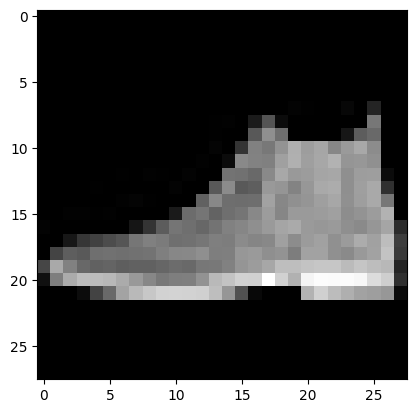

Predict: Ankle Boot


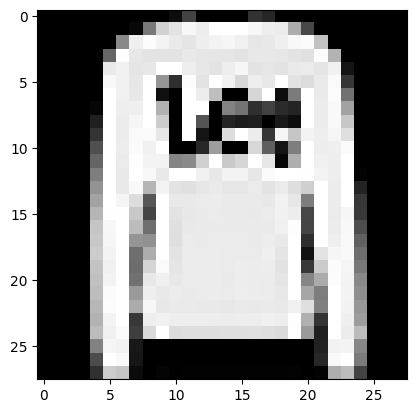

Predict: Pullover


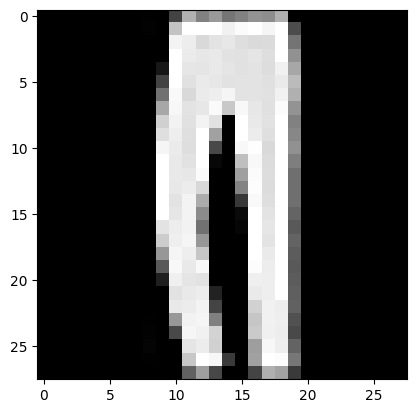

Predict: Trouser


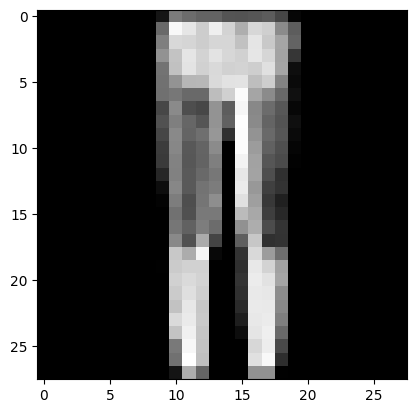

Predict: Trouser


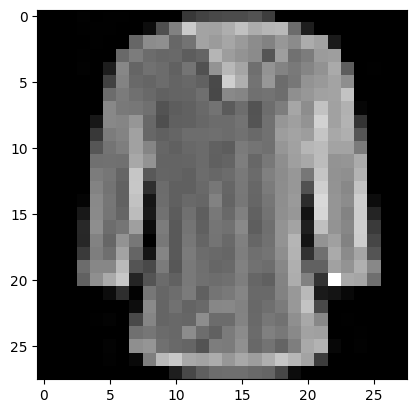

Predict: Shirt


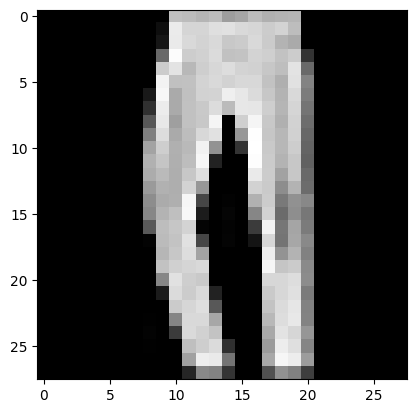

Predict: Trouser


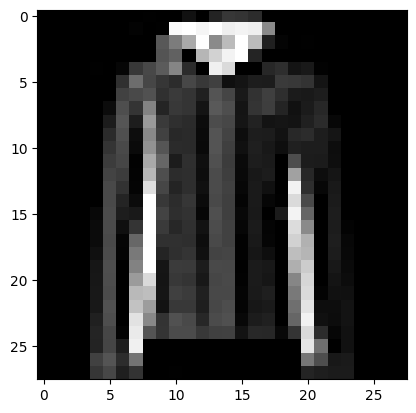

Predict: Coat


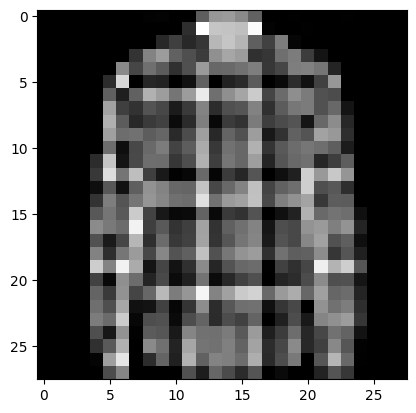

Predict: Shirt


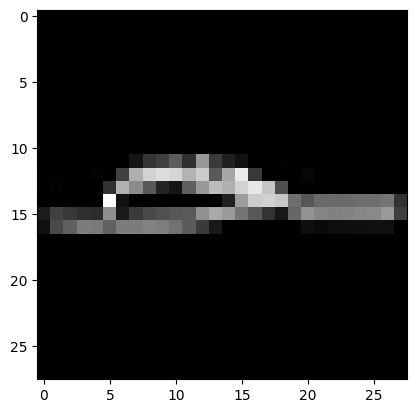

Predict: Sandal


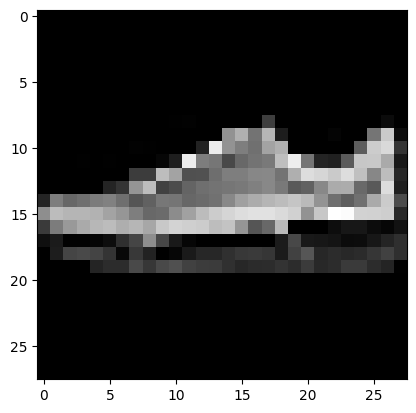

Predict: Sneaker


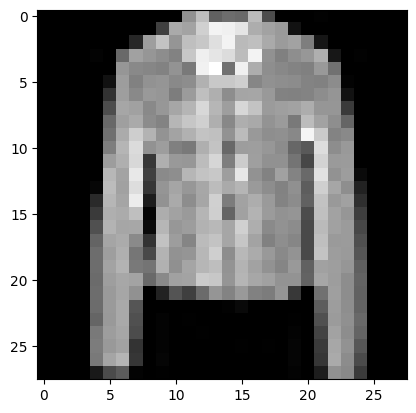

Predict: Coat


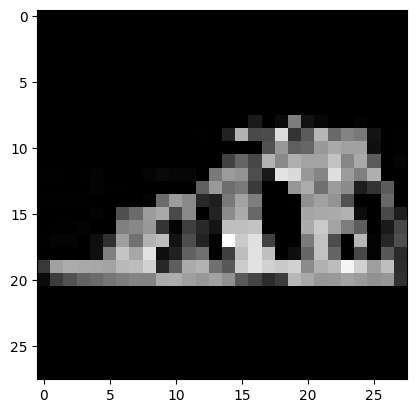

Predict: Sandal


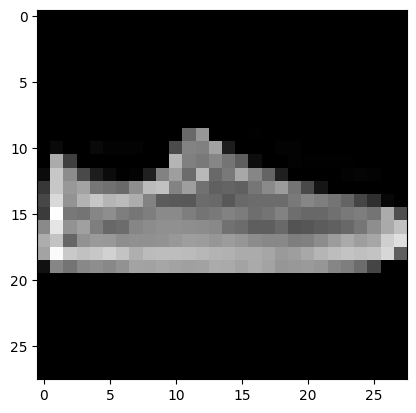

Predict: Sandal


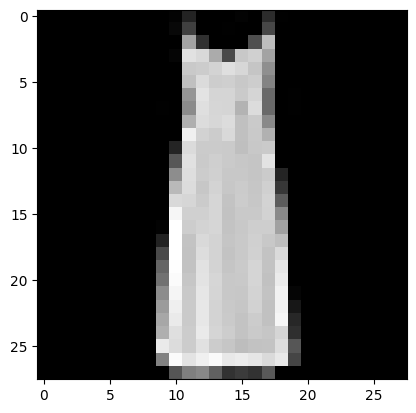

Predict: Dress


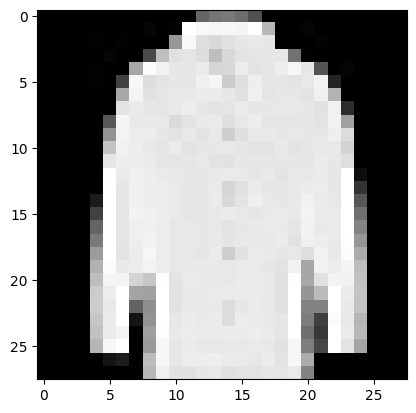

Predict: Coat


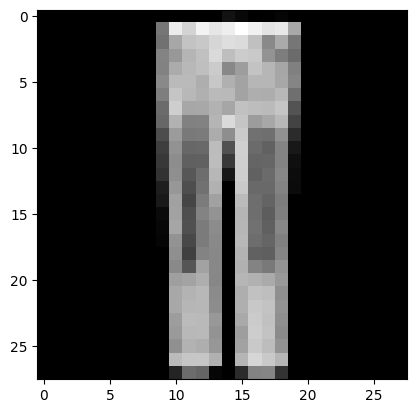

Predict: Trouser


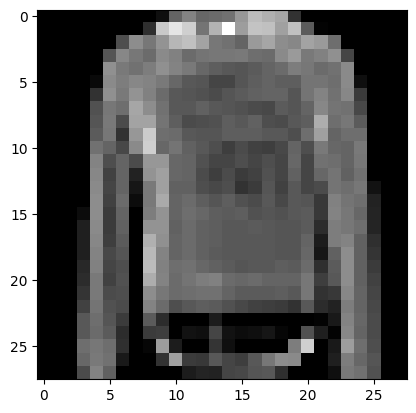

Predict: Pullover


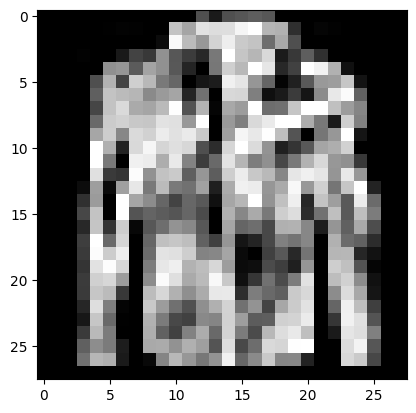

Predict: Pullover


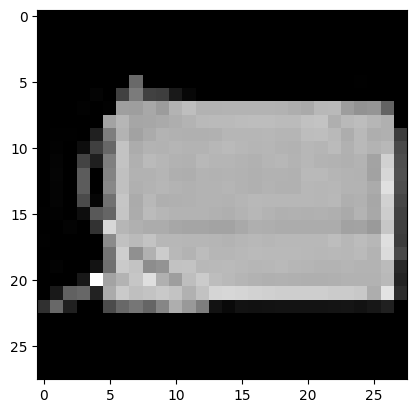

Predict: Bag


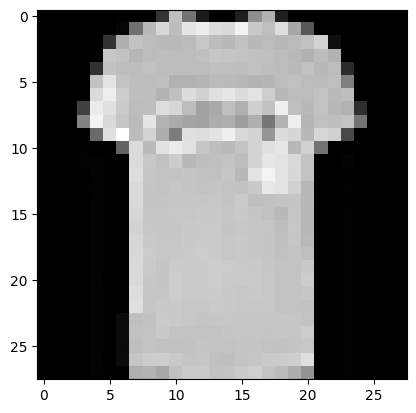

Predict: T-Shirt


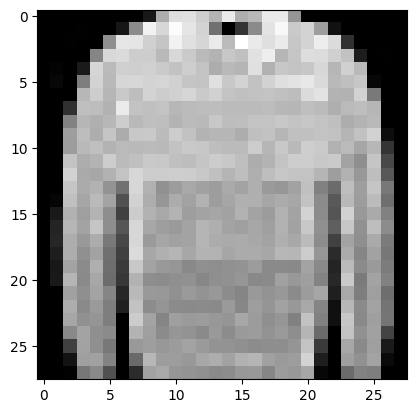

Predict: Pullover


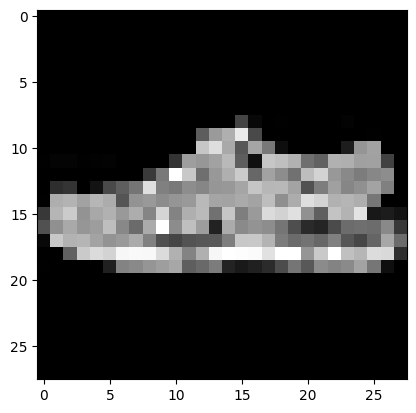

Predict: Sandal


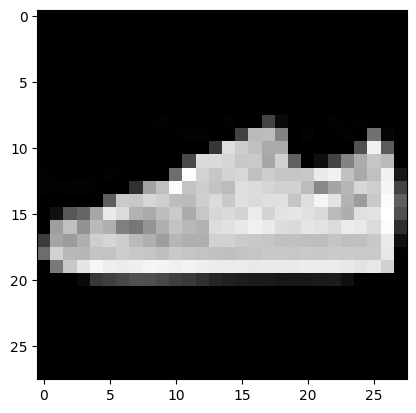

Predict: Sneaker


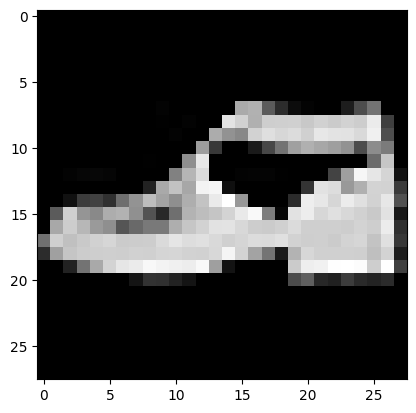

Predict: Sandal


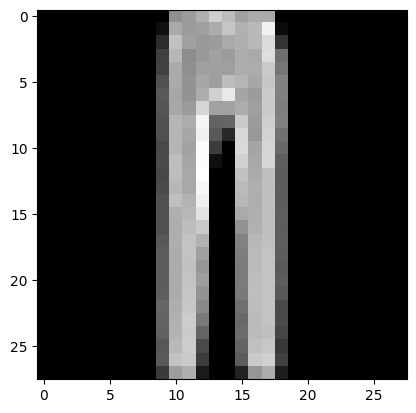

Predict: Trouser


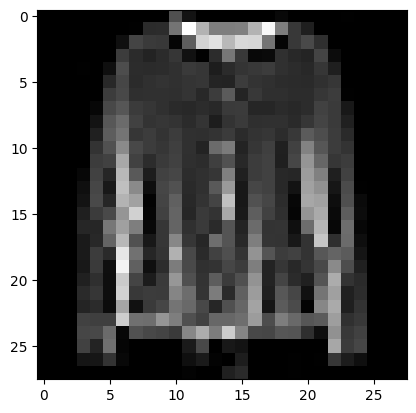

Predict: Coat


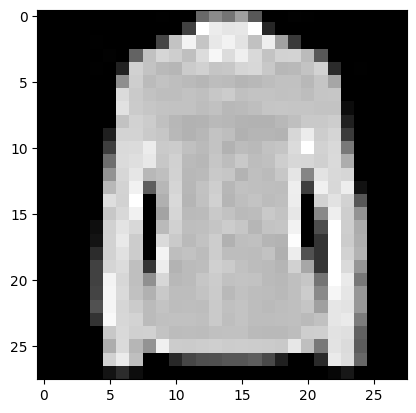

Predict: Shirt


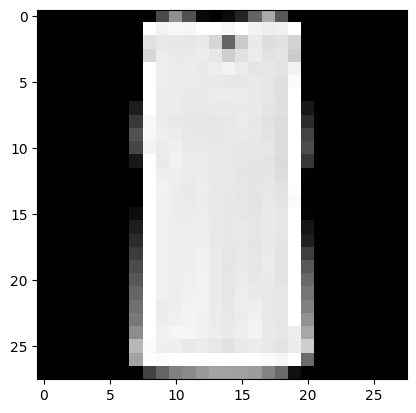

Predict: T-Shirt


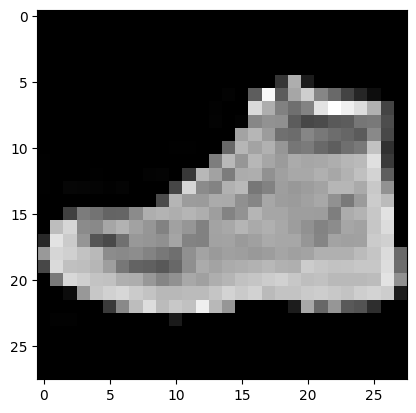

Predict: Ankle Boot


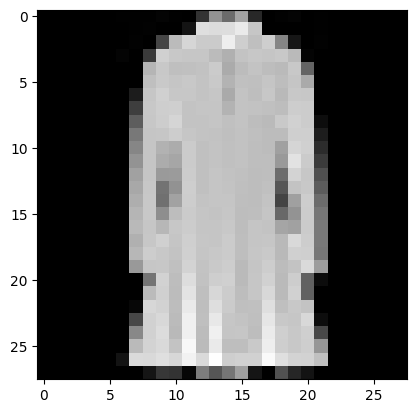

Predict: Dress


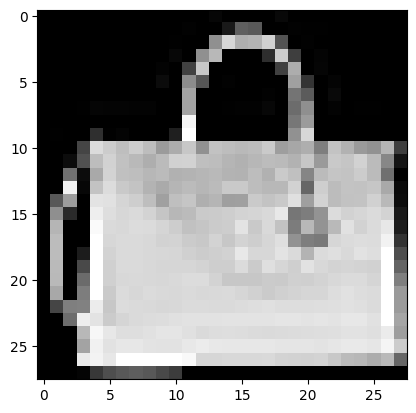

Predict: Bag


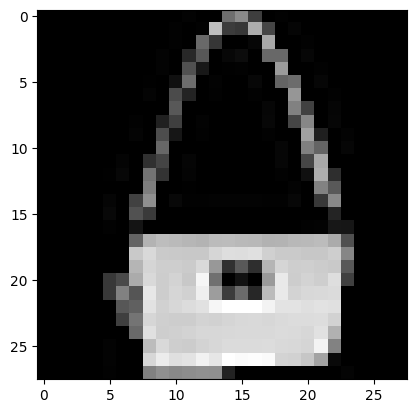

Predict: Bag


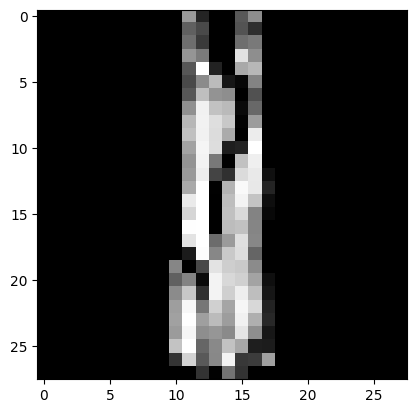

Predict: Dress


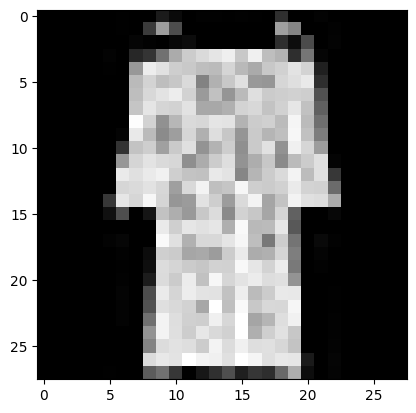

Predict: Dress


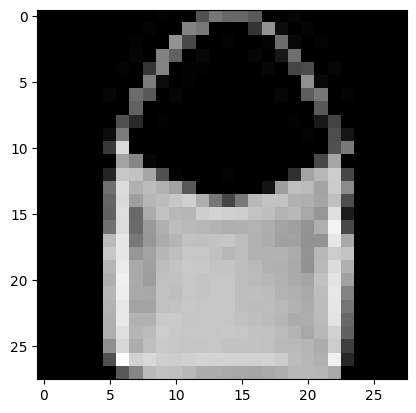

Predict: Bag


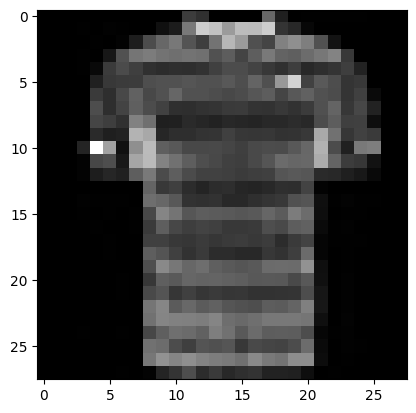

Predict: T-Shirt


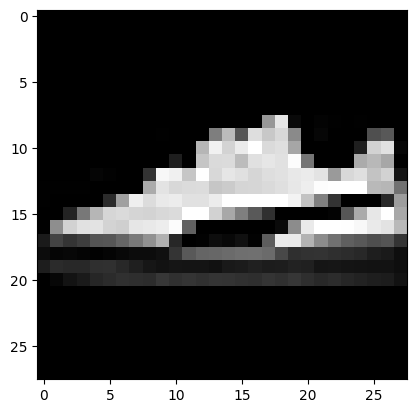

Predict: Sneaker


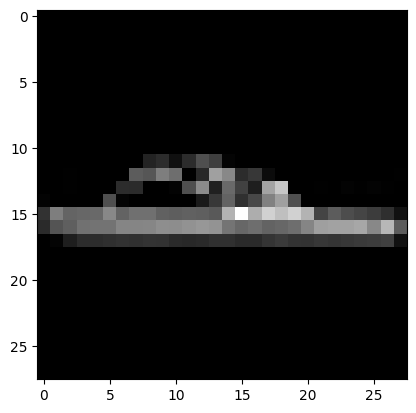

Predict: Sandal


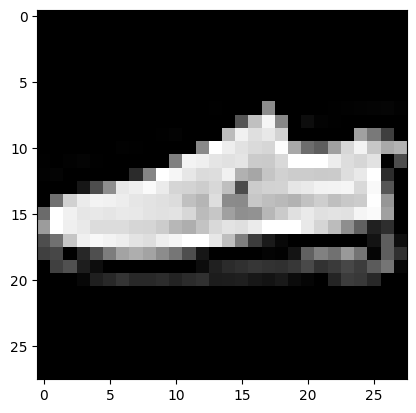

Predict: Sneaker


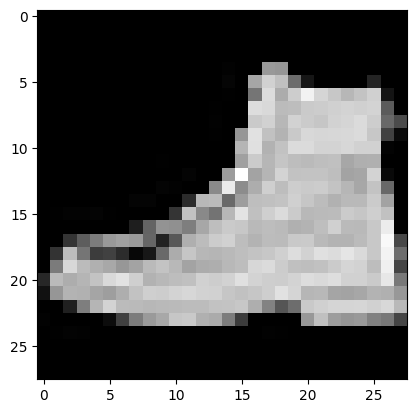

Predict: Ankle Boot


In [18]:
######################## 문제 5 ########################
# 1. 테스트를 통해 30개 출력해보기
n_test = 40
test(model, x[:n_test], y[:n_test], to_be_shown=True)
########################################################